In [123]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from kneed import KneeLocator
from sklearn.inspection import permutation_importance
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from scipy import stats
from sklearn.model_selection import ShuffleSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [124]:
# import data
X_train_engineered = pd.read_pickle('data/X_train_engineered.pkl')
X_test_engineered = pd.read_pickle('data/X_test_engineered.pkl')
# X_train_engineered = pd.read_pickle('data/X_train_scaled.pkl')
# X_test_engineered = pd.read_pickle('data/X_test_scaled.pkl')
y_train_motor = pd.read_pickle('data/y_train_motor.pkl')
y_test_motor = pd.read_pickle('data/y_test_motor.pkl')

## Feature Selection

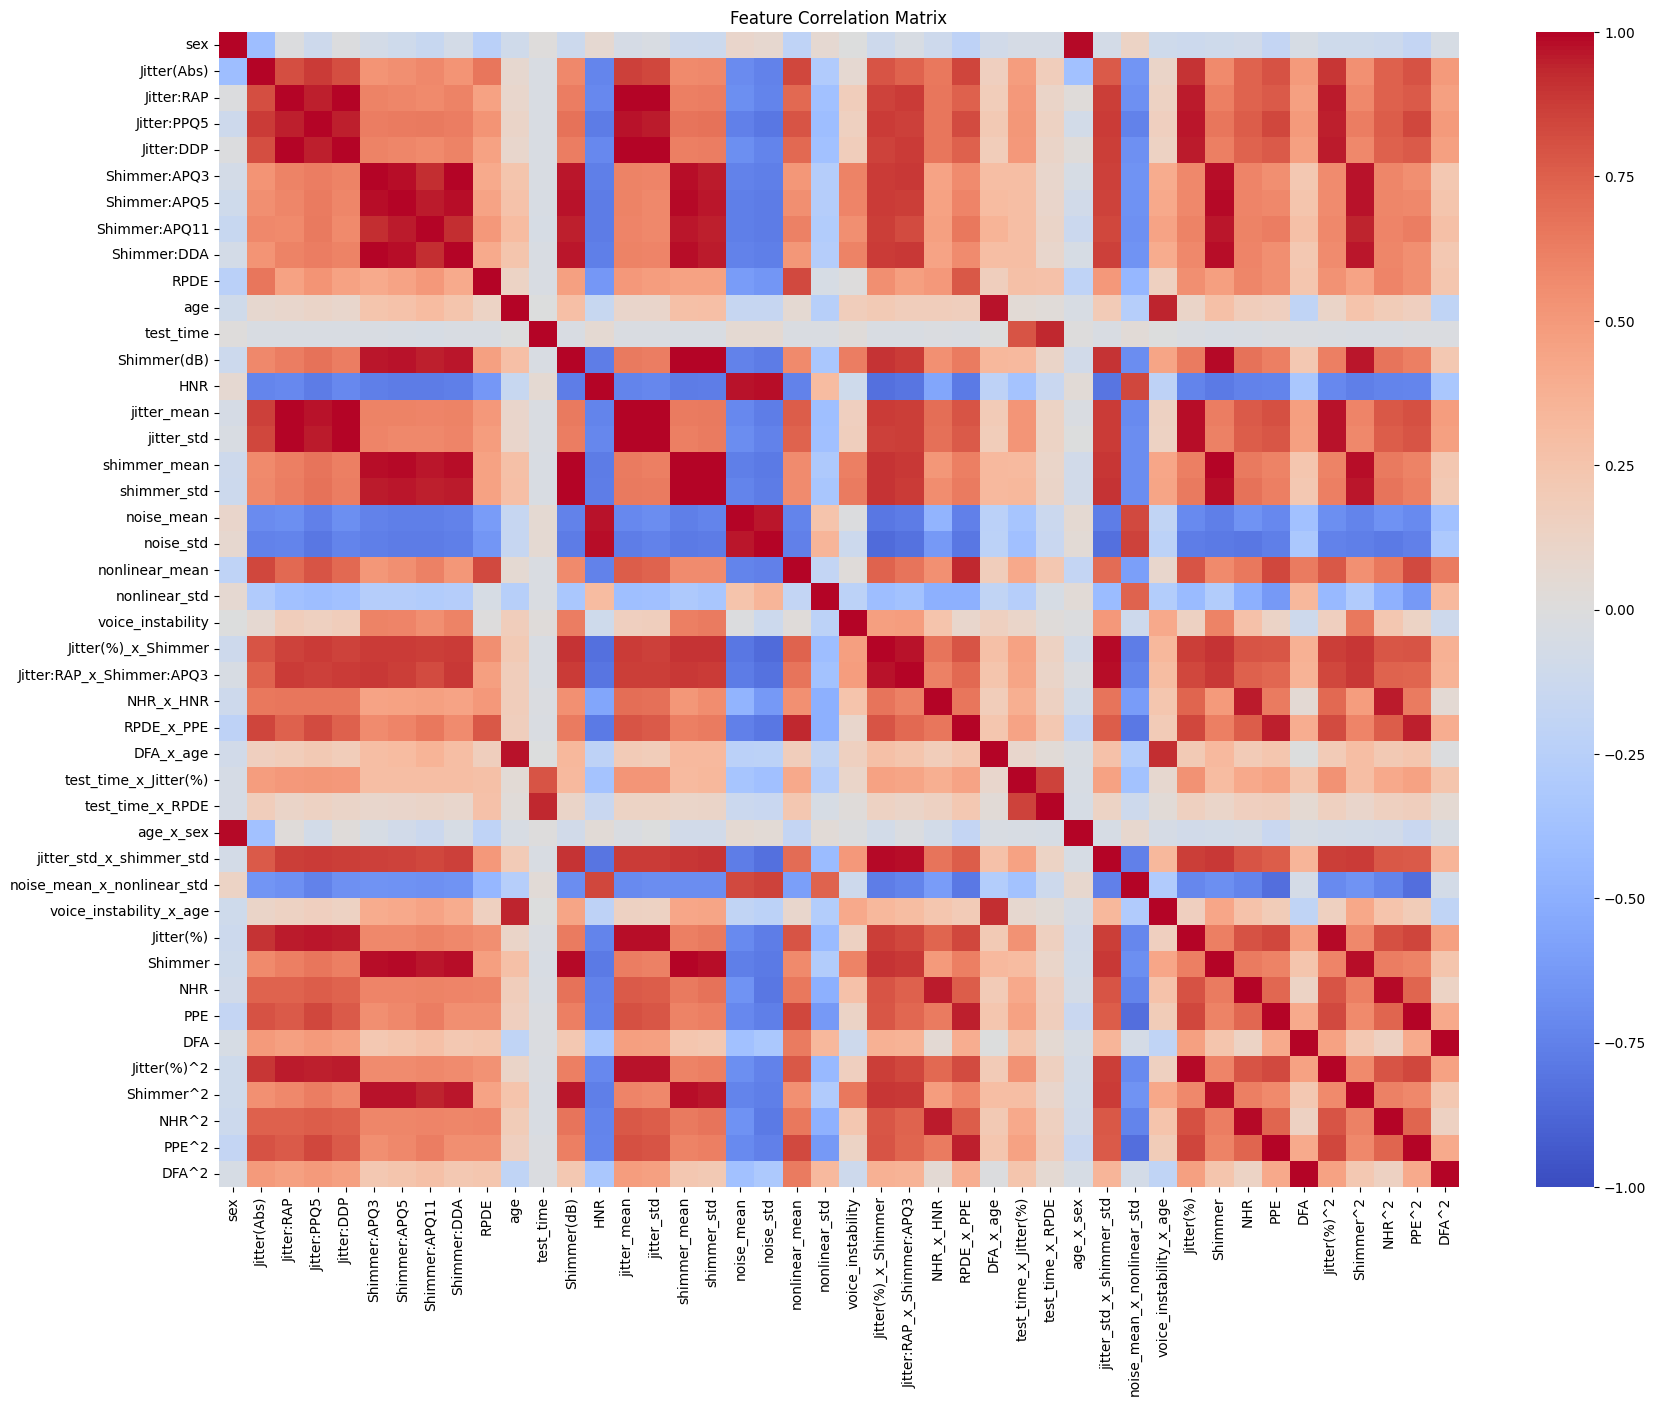

In [125]:
# Calculate correlation matrix
corr_matrix = X_train_engineered.corr()

# Plot heatmap (optional but helpful)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

As we can see a lot of features are higly correlated and can be removed. It was important to do feature engineering and add other features that could potentially capture more information about the intercation of the features and their polynomials than the features on their own.

### Correlation

In [121]:
# correlation based
def select_by_correlation(X_train, y_train, threshold=0.2):
    """
    Select features based on correlation with target
    """
    corr = pd.concat([X_train, y_train], axis=1).corr()
    target_corr = corr[y_train.name].abs().sort_values(ascending=False)
    selected_features = target_corr[target_corr > threshold].index.tolist()
    selected_features.remove(y_train.name)  # Remove target from features
    return selected_features

motor_features_corr = select_by_correlation(X_train_engineered, y_train_motor)
print(f"Selected features based on correlation: {motor_features_corr}")
print(f"Number of selected features: {len(motor_features_corr)}")

Selected features based on correlation: ['age', 'noise_mean_x_nonlinear_std', 'DFA_x_age', 'voice_instability_x_age', 'nonlinear_std', 'noise_mean', 'noise_std', 'HNR']
Number of selected features: 8


### RFE

In [4]:
# recursive feature elimination
def select_by_rfe_cv(X_train, y_train, min_features=5, step=5, cv=5):
    """
    Dynamically select features using RFE with cross-validation.
    Returns: Optimal features and best number of features.
    """
    estimator = LinearRegression()
    selector = RFECV(
        estimator, 
        min_features_to_select=min_features,  # Minimum features to consider
        step=step,                           # Features to drop each iteration
        cv=cv,                               # Cross-validation folds
        scoring='r2'                         # Metric to optimize (or 'neg_mean_absolute_error')
    )
    selector.fit(X_train, y_train)
    
    selected_features = X_train.columns[selector.support_]
    print(f"Optimal number of features: {selector.n_features_}")
    return selected_features.tolist()

motor_features_rfe_cv = select_by_rfe_cv(X_train_engineered, y_train_motor)
print(f"Selected features using RFE: {motor_features_rfe_cv}")

Optimal number of features: 5
Selected features using RFE: ['Shimmer:APQ3', 'Shimmer:DDA', 'Shimmer(dB)', 'shimmer_mean', 'shimmer_std']


In [5]:
def select_by_rfe_dynamic(X_train, y_train, max_features=20, min_features=5, step=1, threshold=0.02):
    """
    Dynamic RFE that stops when performance drops beyond a threshold.
    """
    estimator = LinearRegression()
    scores = []
    feature_counts = range(max_features, min_features - 1, -step)
    
    for n_features in feature_counts:
        selector = RFE(estimator, n_features_to_select=n_features)
        X_selected = selector.fit_transform(X_train, y_train)
        
        # Score with cross-validation (e.g., R²)
        score = cross_val_score(estimator, X_selected, y_train, cv=5, scoring='r2').mean()
        scores.append(score)
        
        # Stop if score drops significantly
        if len(scores) > 1 and (scores[-2] - scores[-1]) > threshold:
            best_n = feature_counts[len(scores) - 2]  # Previous count was better
            selector = RFE(estimator, n_features_to_select=best_n).fit(X_train, y_train)
            return X_train.columns[selector.support_].tolist()
    
    # If no drop, return min_features
    selector = RFE(estimator, n_features_to_select=min_features).fit(X_train, y_train)
    return X_train.columns[selector.support_].tolist()

# Usage
motor_features_rfe = select_by_rfe_dynamic(X_train_engineered, y_train_motor)
print(f"Selected features using dynamic RFE: {motor_features_rfe}")
print(f'Optimal number of features selected: {len(motor_features_rfe)}')

Selected features using dynamic RFE: ['Shimmer:APQ3', 'Shimmer:APQ11', 'Shimmer:DDA', 'Shimmer(dB)', 'shimmer_mean', 'shimmer_std', 'nonlinear_mean', 'Jitter(%)_x_Shimmer', 'RPDE_x_PPE', 'jitter_std_x_shimmer_std', 'noise_mean_x_nonlinear_std', 'Jitter(%)', 'Shimmer', 'PPE', 'DFA', 'PPE^2', 'DFA^2']
Optimal number of features selected: 17


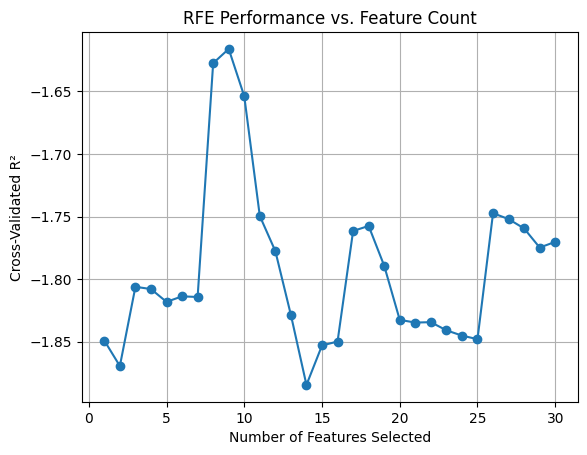

In [6]:
def plot_rfe_performance(X_train, y_train, max_features=30):
    estimator = LinearRegression()
    feature_counts = range(1, max_features + 1)
    scores = []
    
    for n in feature_counts:
        selector = RFE(estimator, n_features_to_select=n)
        X_selected = selector.fit_transform(X_train, y_train)
        score = cross_val_score(estimator, X_selected, y_train, cv=5, scoring='r2').mean()
        scores.append(score)
    
    plt.plot(feature_counts, scores, 'o-')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validated R²")
    plt.title("RFE Performance vs. Feature Count")
    plt.grid()
    plt.show()

plot_rfe_performance(X_train_engineered, y_train_motor)

### Model based

In [7]:
# feature importance from tree based models
def select_by_feature_importance(X_train, y_train, threshold='mean'):
    """
    Select features based on importance from Random Forest
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    if threshold == 'mean':
        threshold = importances.mean()
    
    selected_features = X_train.columns[importances > threshold]
    return selected_features.tolist()

motor_features_imp = select_by_feature_importance(X_train_engineered, y_train_motor)
print(f"Selected features using feature importance: {motor_features_imp}")
print(f'Optimal number of features selected: {len(motor_features_imp)}')

Selected features using feature importance: ['RPDE', 'age', 'test_time', 'voice_instability', 'DFA_x_age', 'age_x_sex']
Optimal number of features selected: 6


In [128]:
# def select_by_feature_importance_perc(X_train, y_train, percentile=50):
#     """
#     Select top features based on importance percentile.
#     """
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train)
#     importances = model.feature_importances_
    
#     # Calculate threshold as percentile (e.g., 50th percentile = median)
#     threshold = np.percentile(importances, percentile)
#     selected_features = X_train.columns[importances >= threshold]
    
#     print(f"Threshold ({percentile}th percentile): {threshold:.4f}")
#     return selected_features.tolist()

# # Usage: Keep top 50% most important features
# motor_features_imp_perc = select_by_feature_importance(X_train_engineered, y_train_motor, percentile=50)
# print(f"Selected features using feature importance (50th percentile): {motor_features_imp_perc}")
# print(f'Optimal number of features selected: {len(motor_features_imp_perc)}')

In [129]:
# !pip install kneed

In [9]:
def select_by_importance_elbow(X_train, y_train):
    """
    Automatically find the "elbow point" in feature importance.
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    # Sort features by importance (descending)
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    
    # Find elbow point (point of diminishing returns)
    kneedle = KneeLocator(
        range(len(sorted_importances)),
        sorted_importances,
        curve='convex',
        direction='decreasing'
    )
    optimal_idx = kneedle.elbow
    threshold = sorted_importances[optimal_idx]
    
    selected_features = X_train.columns[importances >= threshold]
    print(f"Elbow threshold: {threshold:.4f} (kept {len(selected_features)} features)")
    return selected_features.tolist()

motor_features_imp_elbow = select_by_importance_elbow(X_train_engineered, y_train_motor)
print(f"Selected features using feature importance (elbow method): {motor_features_imp_elbow}")
print(f'Optimal number of features selected: {len(motor_features_imp_elbow)}')

Elbow threshold: 0.0290 (kept 5 features)
Selected features using feature importance (elbow method): ['RPDE', 'age', 'test_time', 'DFA_x_age', 'age_x_sex']
Optimal number of features selected: 5


In [10]:
def select_by_permutation_importance(X_train, y_train, n_repeats=10, threshold=0.01):
    """
    Select features with statistically significant importance.
    """
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Compute permutation importance
    result = permutation_importance(
        model, X_train, y_train, n_repeats=n_repeats, random_state=42
    )
    importances = result.importances_mean
    
    # Select features where importance > threshold
    selected_features = X_train.columns[importances > threshold]
    print(f"Features with permutation importance > {threshold}: {len(selected_features)}")
    return selected_features.tolist()

motor_features_imp_perm = select_by_permutation_importance(X_train_engineered, y_train_motor)
print(f"Selected features using permutation importance: {motor_features_imp_perm}")
print(f'Optimal number of features selected: {len(motor_features_imp_perm)}')

Features with permutation importance > 0.01: 8
Selected features using permutation importance: ['sex', 'Jitter(Abs)', 'RPDE', 'age', 'test_time', 'DFA_x_age', 'age_x_sex', 'voice_instability_x_age']
Optimal number of features selected: 8


### Mutual information

In [11]:
# mutual information
def select_by_mutual_info(X_train, y_train, n_features=10):
    """
    Select features based on mutual information
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    selected_features = mi_series.sort_values(ascending=False).head(n_features).index
    return selected_features.tolist()

motor_features_mi = select_by_mutual_info(X_train_engineered, y_train_motor)
print(f"Selected features using mutual information: {motor_features_mi}")
print(f'Optimal number of features selected: {len(motor_features_mi)}')

Selected features using mutual information: ['test_time', 'age', 'age_x_sex', 'DFA_x_age', 'voice_instability_x_age', 'sex', 'test_time_x_RPDE', 'test_time_x_Jitter(%)', 'DFA', 'DFA^2']
Optimal number of features selected: 10


In [12]:
def select_by_mi_percentile(X_train, y_train, percentile=50):
    """
    Select features with MI in the top percentile (default: top 50%).
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    
    # Calculate threshold
    threshold = np.percentile(mi, percentile)
    selected_features = mi_series[mi_series >= threshold].index.tolist()
    
    print(f"Selected {len(selected_features)} features (MI ≥ {threshold:.4f})")
    return selected_features

# Keep top 25% of features
motor_features_mi_perc = select_by_mi_percentile(X_train_engineered, y_train_motor, percentile=75)
print(f"Selected features using mutual information (75th percentile): {motor_features_mi_perc}")
print(f'Optimal number of features selected: {len(motor_features_mi_perc)}')

Selected 11 features (MI ≥ 0.1392)
Selected features using mutual information (75th percentile): ['sex', 'age', 'test_time', 'noise_std', 'DFA_x_age', 'test_time_x_Jitter(%)', 'test_time_x_RPDE', 'age_x_sex', 'voice_instability_x_age', 'DFA', 'DFA^2']
Optimal number of features selected: 11


In [134]:
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.utils import shuffle

# def select_by_mi_significance(X_train, y_train, alpha=0.05, n_permutations=100):
#     """
#     Select features with MI significantly > 0 (via permutation test).
#     """
#     # Compute true MI
#     mi_true = mutual_info_regression(X_train, y_train)
    
#     # Null distribution (shuffled y)
#     mi_null = np.zeros((n_permutations, X_train.shape[1]))
#     for i in range(n_permutations):
#         y_shuffled = shuffle(y_train)
#         mi_null[i, :] = mutual_info_regression(X_train, y_shuffled)
    
#     # Significance threshold (95th percentile of null)
#     threshold = np.percentile(mi_null, 100 * (1 - alpha))
#     significant_features = X_train.columns[mi_true > threshold].tolist()
    
#     print(f"Selected {len(significant_features)} features (p < {alpha})")
#     return significant_features

# motor_features_mi_perm = select_by_mi_significance(X_train_engineered, y_train_motor)
# print(f"Selected features using mutual information (significance test): {motor_features_mi_perm}")
# print(f'Optimal number of features selected: {len(motor_features_mi_perm)}')

In [135]:
# from kneed import KneeLocator

# def select_by_mi_elbow(X_train, y_train):
#     """
#     Select features using the elbow point in sorted MI values.
#     """
#     mi = mutual_info_regression(X_train, y_train)
#     mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
    
#     # Find elbow point
#     kneedle = KneeLocator(
#         range(len(mi_series)),
#         mi_series.values,
#         curve='convex',
#         direction='decreasing'
#     )
#     optimal_n = kneedle.elbow
#     selected_features = mi_series.index[:optimal_n].tolist()
    
#     print(f"Selected {optimal_n} features (elbow threshold: {mi_series[optimal_n]:.4f})")
#     return selected_features

# motor_features_mi_elbow = select_by_mi_elbow(X_train_engineered, y_train_motor)
# print(f"Selected features using mutual information (elbow method): {motor_features_mi_elbow}")
# print(f'Optimal number of features selected: {len(motor_features_mi_elbow)}')

In [13]:
def select_by_mi_adaptive(X_train, y_train, k=1.0):
    """
    Select features with MI > mean + k * std (default: k=1).
    """
    mi = mutual_info_regression(X_train, y_train)
    mi_series = pd.Series(mi, index=X_train.columns)
    
    threshold = mi_series.mean() + k * mi_series.std()
    selected_features = mi_series[mi_series >= threshold].index.tolist()
    
    print(f"Selected {len(selected_features)} features (MI ≥ {threshold:.4f})")
    return selected_features

# More aggressive (k=1.5) or lenient (k=0.5)
motor_features_mi_adapt = select_by_mi_adaptive(X_train_engineered, y_train_motor, k=0.5)
print(f"Selected features using mutual information (adaptive threshold): {motor_features_mi_adapt}")
print(f'Optimal number of features selected: {len(motor_features_mi_adapt)}')

Selected 4 features (MI ≥ 0.8968)
Selected features using mutual information (adaptive threshold): ['age', 'test_time', 'DFA_x_age', 'age_x_sex']
Optimal number of features selected: 4


### Clustering

In [17]:
# agglomerative clustering

def select_by_agglomerative_clustering(X_train, n_clusters=5):
    """
    Select features using Agglomerative Clustering
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clustering.fit(X_train.T)
    clusters = pd.Series(clustering.labels_, index=X_train.columns)
    
    selected_features = []
    for cluster in clusters.unique():
        cluster_features = clusters[clusters == cluster].index.tolist()
        selected_features.append(cluster_features[0])  # Select one feature from each cluster
    
    return selected_features

motor_features_agglom = select_by_agglomerative_clustering(X_train_engineered, n_clusters=5)
print(f"Selected features using Agglomerative Clustering: {motor_features_agglom}")

Selected features using Agglomerative Clustering: ['sex', 'Jitter(Abs)', 'Shimmer:APQ3', 'age', 'test_time']


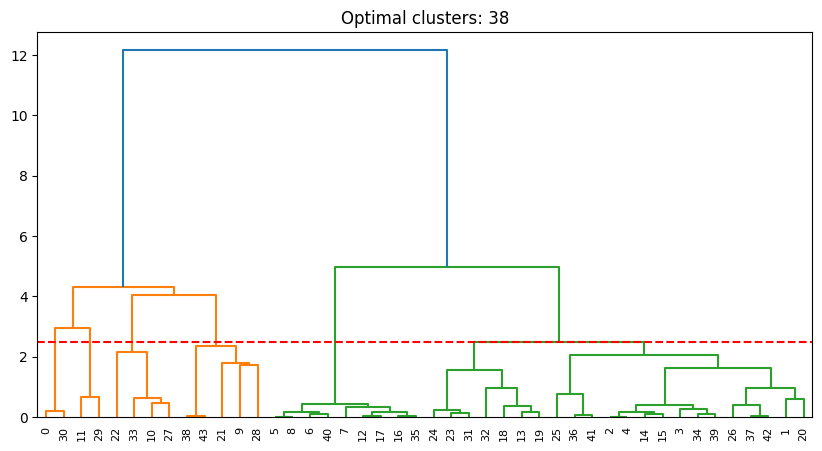

In [18]:
def find_optimal_clusters(feature_corr, max_clusters=10):
    """
    Find optimal cluster count using the elbow method on linkage distances.
    """
    Z = linkage(feature_corr, method='ward')
    
    # Calculate distances between merges
    distances = Z[:, 2]
    x = range(1, len(distances)+1)
    
    # Find elbow point
    kn = KneeLocator(x, distances, curve='convex', direction='increasing')
    optimal_clusters = kn.elbow or max_clusters  # Fallback to max_clusters
    
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.axhline(y=distances[optimal_clusters-1], color='r', linestyle='--')
    plt.title(f"Optimal clusters: {optimal_clusters}")
    plt.show()
    
    return optimal_clusters

feature_corr = X_train_engineered.corr().abs().values  # Absolute correlation matrix
optimal_clusters = find_optimal_clusters(feature_corr)

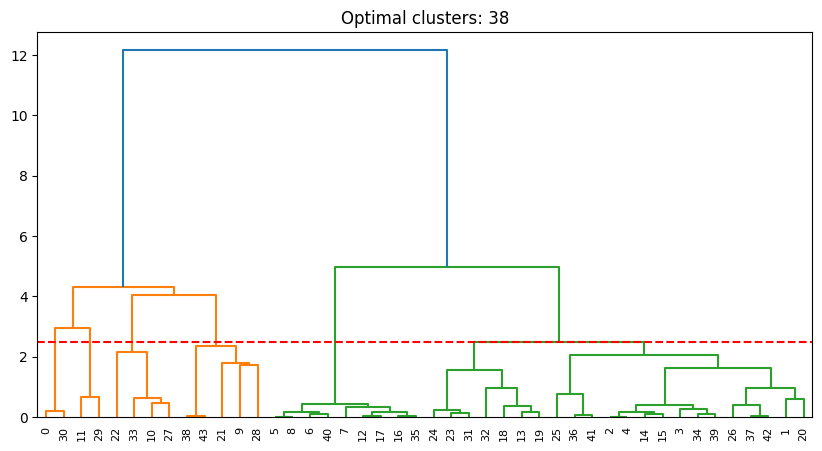

Selected features: ['Jitter:PPQ5', 'NHR', 'test_time_x_RPDE', 'test_time_x_Jitter(%)', 'Jitter:RAP', 'NHR^2', 'Shimmer(dB)', 'Jitter(%)^2', 'Shimmer:APQ5', 'jitter_mean', 'voice_instability', 'NHR_x_HNR', 'Jitter:RAP_x_Shimmer:APQ3', 'jitter_std_x_shimmer_std', 'nonlinear_std', 'PPE', 'RPDE', 'Shimmer:APQ11', 'DFA_x_age', 'sex', 'shimmer_mean', 'noise_mean', 'noise_std', 'Jitter(%)_x_Shimmer', 'age', 'jitter_std', 'DFA', 'noise_mean_x_nonlinear_std', 'Jitter(%)', 'Jitter(Abs)', 'test_time', 'Shimmer^2', 'voice_instability_x_age', 'Shimmer:APQ3', 'nonlinear_mean', 'RPDE_x_PPE', 'HNR', 'age_x_sex']


c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [19]:
def select_from_clusters(X_train, n_clusters=None):
    """
    Select representative features from clusters using correlation analysis.
    """
    corr_matrix = X_train.corr().abs()
    
    # Auto-determine clusters if not specified
    if n_clusters is None:
        n_clusters = find_optimal_clusters(corr_matrix.values)
    
    # Cluster features
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters, 
        # affinity='precomputed', 
        linkage='complete'
    )
    clusters = clustering.fit_predict(1 - corr_matrix)  # Convert similarity to distance
    
    selected_features = []
    for cluster_id in np.unique(clusters):
        cluster_features = corr_matrix.columns[clusters == cluster_id]
        
        # Strategy 1: Select feature with highest average correlation to others in cluster
        rep_feature = corr_matrix.loc[cluster_features, cluster_features].mean().idxmax()
        selected_features.append(rep_feature)
        
        # Strategy 2: Add secondary features with correlation < threshold
        secondary_features = [
            f for f in cluster_features 
            if corr_matrix.loc[f, rep_feature] < 0.7  # Anti-correlation threshold
        ]
        selected_features.extend(secondary_features[:2])  # Keep at most 2 extras
    
    return list(set(selected_features))  # Remove duplicates

# Usage
motor_features_agglom_dynamic = select_from_clusters(X_train_engineered)
print(f"Selected features: {motor_features_agglom_dynamic}")

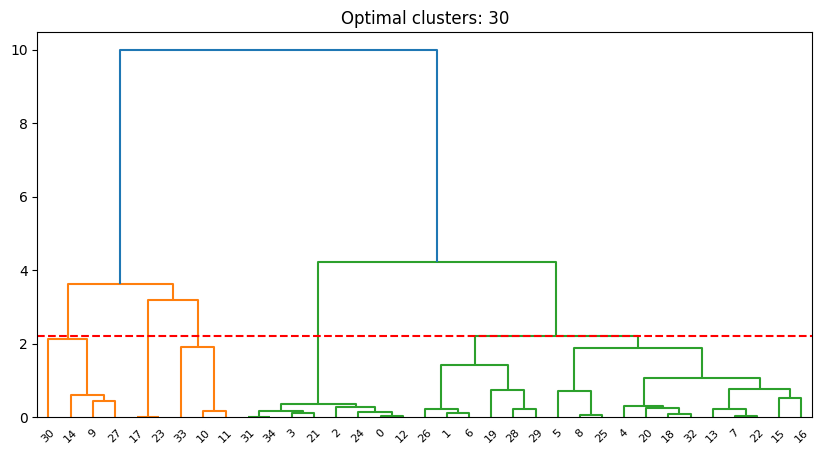

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


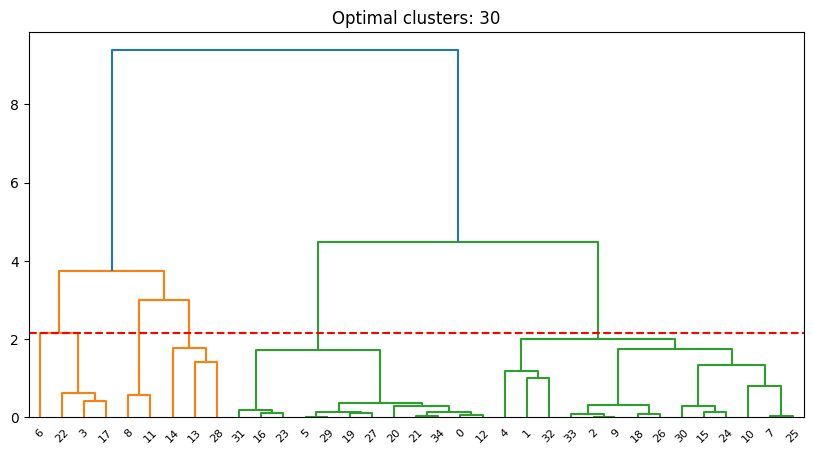

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


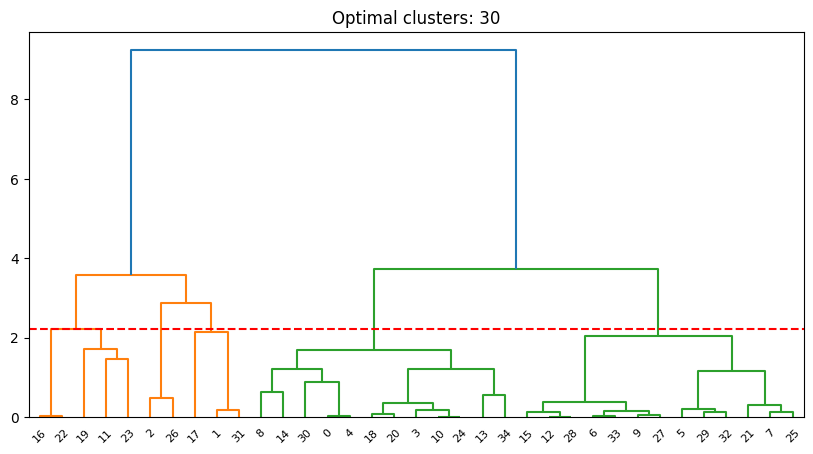

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


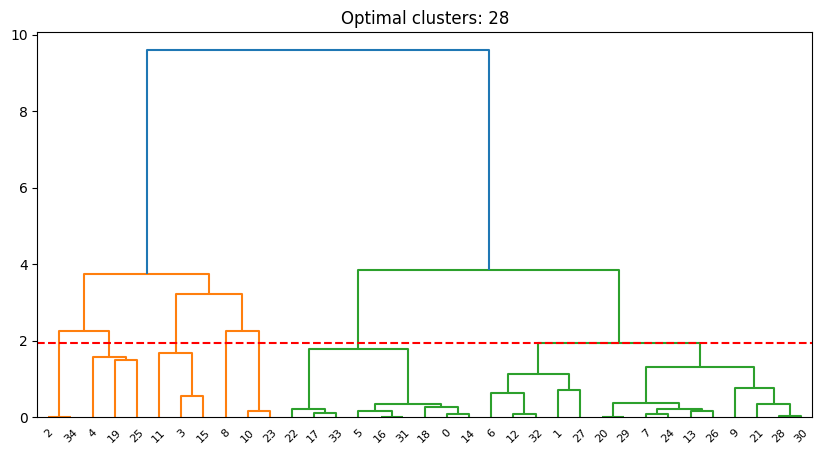

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


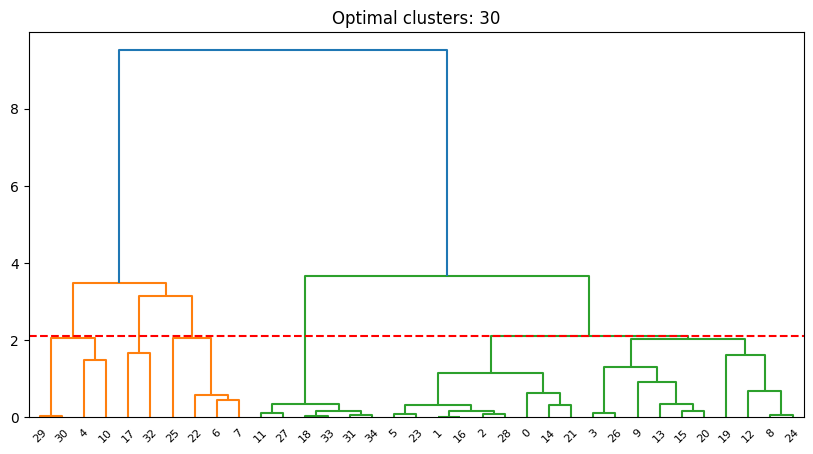

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


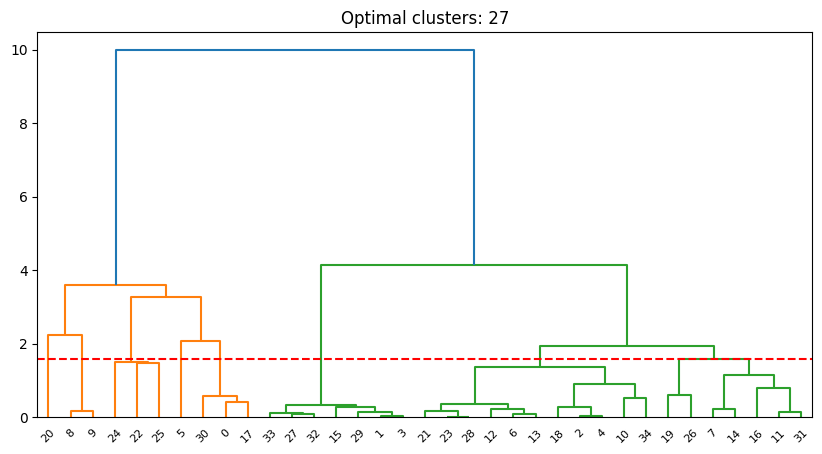

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


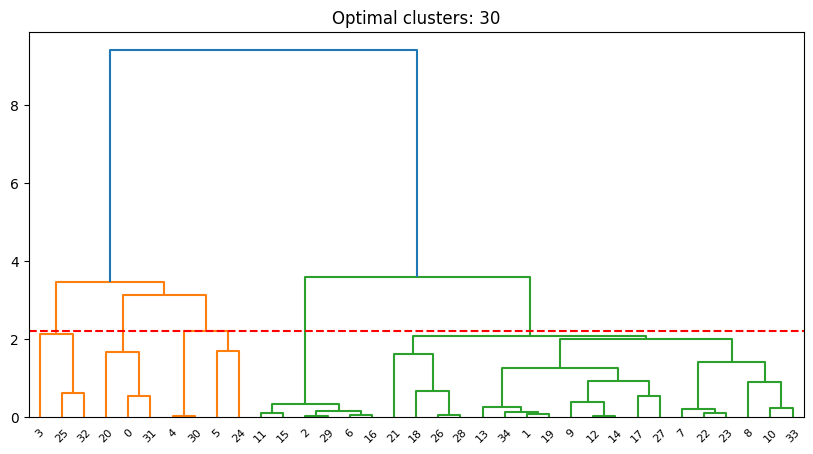

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


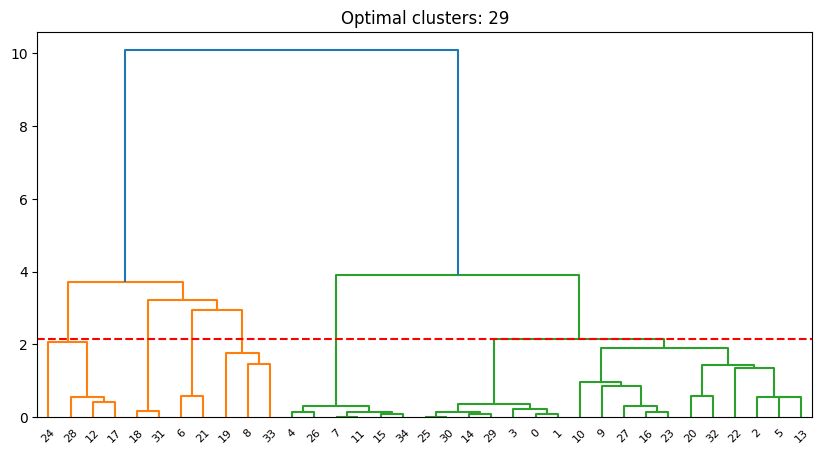

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


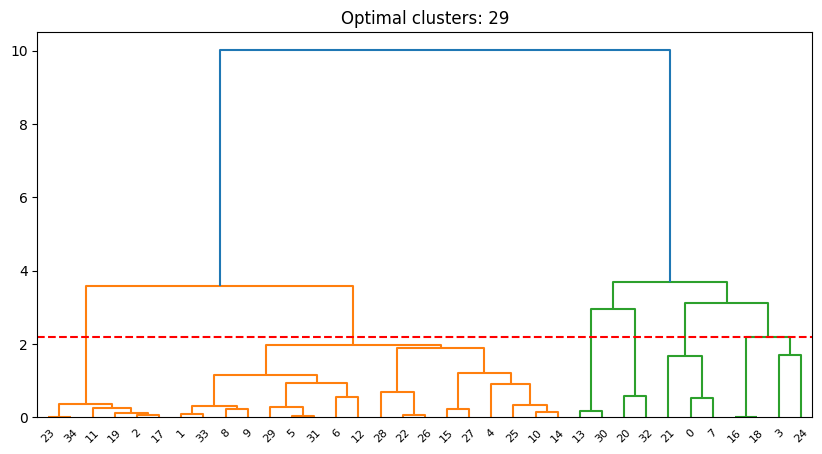

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


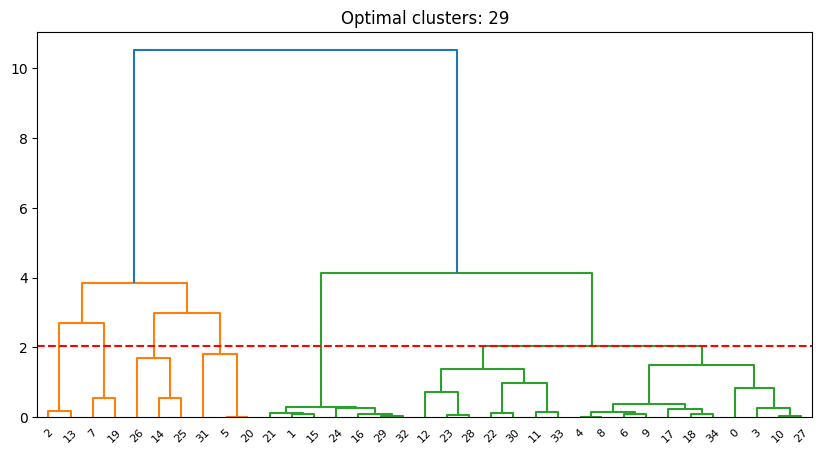

Stable features across iterations: ['noise_mean_x_nonlinear_std', 'voice_instability_x_age', 'voice_instability', 'NHR_x_HNR', 'age_x_sex', 'Jitter(%)_x_Shimmer', 'Jitter(%)^2', 'nonlinear_std', 'age', 'Jitter(Abs)', 'nonlinear_mean', 'Jitter:RAP_x_Shimmer:APQ3', 'test_time_x_Jitter(%)', 'HNR', 'test_time', 'noise_std', 'RPDE_x_PPE', 'test_time_x_RPDE', 'jitter_std_x_shimmer_std', 'Shimmer:APQ5', 'jitter_mean', 'noise_mean', 'sex', 'DFA_x_age', 'Jitter:PPQ5', 'Shimmer', 'Shimmer:APQ11', 'PPE', 'Jitter(%)', 'DFA', 'NHR', 'RPDE', 'Jitter:DDP', 'Jitter:RAP', 'Shimmer(dB)', 'Shimmer:APQ3']
Optimal number of features selected: 36


c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [20]:
def stable_feature_selection(X_train, n_iter=10):
    """Select features that consistently appear in clusters across iterations."""
    all_selected = []
    for _ in range(n_iter):
        # Subsample data
        X_sample = X_train.sample(frac=0.8, axis=1)  # Columns (features)
        features = select_from_clusters(X_sample)
        all_selected.extend(features)
    
    # Count feature occurrences
    feature_counts = pd.Series(all_selected).value_counts()
    stable_features = feature_counts[feature_counts >= n_iter//2].index.tolist()
    
    return stable_features

stable_features = stable_feature_selection(X_train_engineered)
print(f"Stable features across iterations: {stable_features}")
print(f'Optimal number of features selected: {len(stable_features)}')

c:\Users\vikto\Desktop\Uni\Third year subjects\Biosignals\.venv\lib\site-packages\scipy\cluster\hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
C:\Users\vikto\AppData\Local\Temp\ipykernel_16548\440683901.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage=linkage(1 - corr.abs().values, method='complete'),
C:\Users\vikto\AppData\Local\Temp\ipykernel_16548\440683901.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  col_linkage=linkage(1 - corr.abs().values, method='complete'),


Cluster 0: sex, test_time, test_time_x_RPDE, age_x_sex
Cluster 1: Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP, HNR, jitter_mean, jitter_std, noise_mean, noise_std, nonlinear_mean, Jitter(%)_x_Shimmer, Jitter:RAP_x_Shimmer:APQ3, NHR_x_HNR, RPDE_x_PPE, jitter_std_x_shimmer_std, noise_mean_x_nonlinear_std, Jitter(%), NHR, PPE, Jitter(%)^2, NHR^2, PPE^2
Cluster 2: Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11, Shimmer:DDA, Shimmer(dB), shimmer_mean, shimmer_std, Shimmer, Shimmer^2
Cluster 3: RPDE, nonlinear_std, test_time_x_Jitter(%), DFA, DFA^2
Cluster 4: age, voice_instability, DFA_x_age, voice_instability_x_age


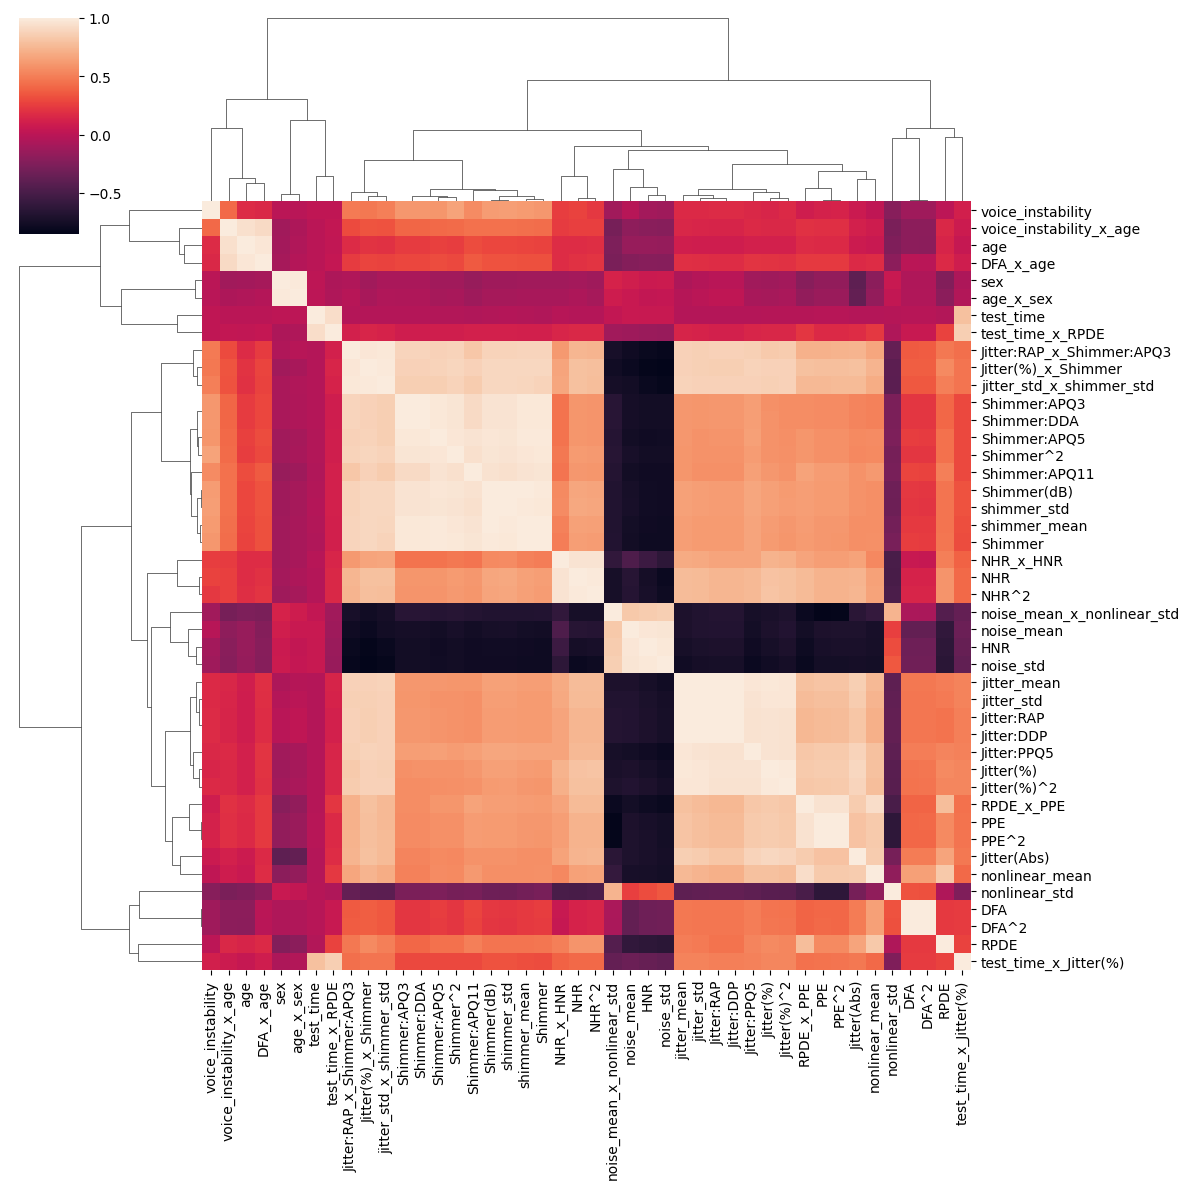

In [23]:
def plot_clustered_corr(X, clusters):
    """Plot correlation matrix with cluster annotations."""
    corr = X.corr()
    sns.clustermap(
        corr, 
        row_linkage=linkage(1 - corr.abs().values, method='complete'),
        col_linkage=linkage(1 - corr.abs().values, method='complete'),
        figsize=(12, 12)
    )
    
    # Add cluster labels
    for i, cluster_id in enumerate(np.unique(clusters)):
        features = corr.columns[clusters == cluster_id]
        print(f"Cluster {cluster_id}: {', '.join(features)}")

# Usage
clusters = AgglomerativeClustering(n_clusters=5).fit_predict(1 - X_train_engineered.corr().abs())
plot_clustered_corr(X_train_engineered, clusters)

# Compare performance 

In [24]:
from sklearn.linear_model import Lasso, Ridge
# compare the performance of different feature selection methods
def compare_feature_selection_methods(X_train, y_train, methods):
    """
    Compare different feature selection methods based on model performance.
    """
    results = {}
    
    for method in methods:
        if method == 'correlation':
            selected_features = motor_features_corr
        elif method == 'rfecv':
            selected_features = motor_features_rfe_cv
        elif method == 'rfe':
            selected_features = motor_features_rfe
        elif method == 'importance':
            selected_features = motor_features_imp
        # elif method == 'importance_perc':
        #     selected_features = select_by_feature_importance_perc(X_train, y_train, percentile=50)
        elif method == 'importance_elbow':
            selected_features = motor_features_imp_elbow
        elif method == 'importance_perm':
            selected_features = motor_features_imp_perm
        elif method == 'mutual_info':
            selected_features = motor_features_mi
        elif method == 'mutual_info_perc':
            selected_features = motor_features_mi_perc
        # elif method == 'mutual_info_significance':
        #     selected_features = motor_features_mi_perm
        elif method == 'mutual_info_adaptive':
            selected_features = motor_features_mi_adapt
        # elif method == 'mutual_info_elbow':
        #     selected_features = select_by_mi_elbow(X_train, y_train)
        elif method == 'agglomerative':
            selected_features = motor_features_agglom
        elif method == 'agglomerative_dynamic':
            selected_features = motor_features_agglom_dynamic
        elif method == 'agglomerative_stable':
            selected_features = stable_features
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Train model and evaluate performance
        model = Ridge()
        score = cross_val_score(model, X_train[selected_features], y_train, cv=5, scoring='r2').mean()
        results[method] = score
    
    return results

methods = ['correlation', 'rfecv', 'rfe', 'importance', 
          'importance_elbow', 'importance_perm', 'mutual_info', 
          'mutual_info_perc', 'mutual_info_adaptive', 
          'agglomerative', 'agglomerative_dynamic', 'agglomerative_stable']
results = compare_feature_selection_methods(X_train_engineered, y_train_motor, methods)

print("Feature Selection Method Performance R^2:")
for method, score in results.items():
    print(f"{method}: {score:.4f}")

print()
print(f"Best method: {max(results, key=results.get)}")
print(f"Best R^2 score: {results[max(results, key=results.get)]:.4f}")

Feature Selection Method Performance R^2:
correlation: -1.7057
rfecv: -1.7869
rfe: -1.7495
importance: -1.8155
importance_elbow: -1.8223
importance_perm: -2.1241
mutual_info: -2.2380
mutual_info_perc: -2.0967
mutual_info_adaptive: -1.8281
agglomerative: -1.8958
agglomerative_dynamic: -2.0620
agglomerative_stable: -2.0801

Best method: correlation
Best R^2 score: -1.7057


## Results

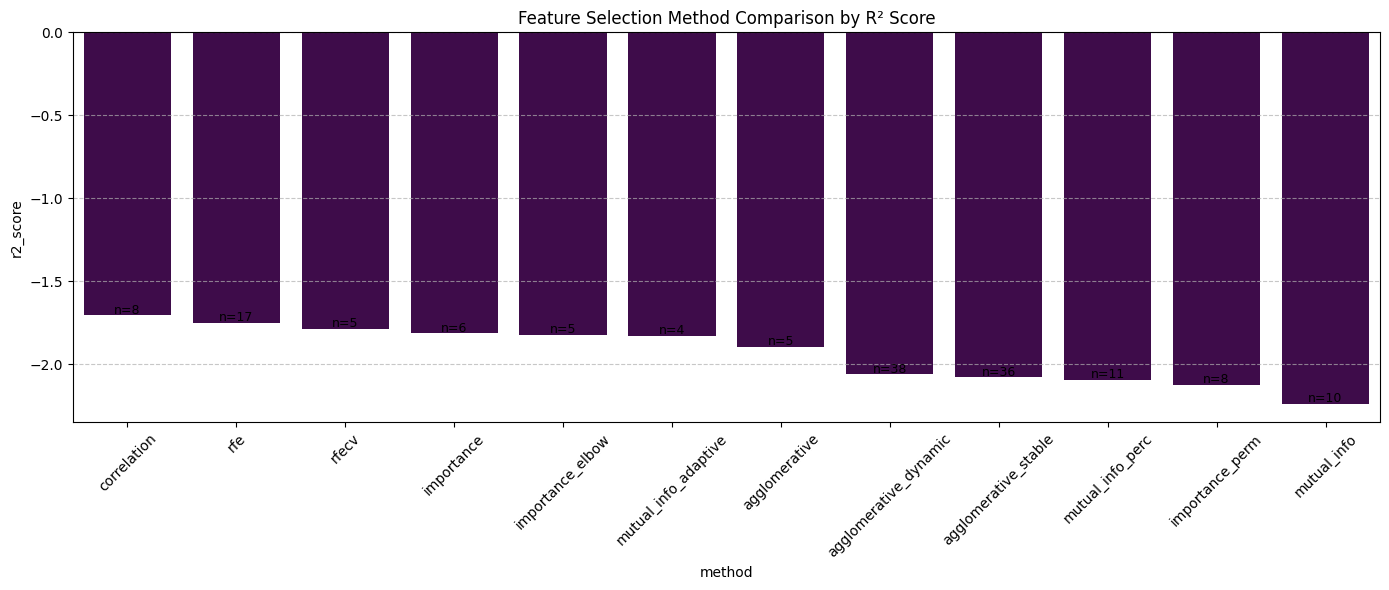

In [26]:
# Convert results dictionary to DataFrame for better visualization
def plot_feature_selection_results(results_dict):
    """
    Plot comparison of feature selection methods based on R² scores
    """
    # Convert dictionary to DataFrame
    results_df = pd.DataFrame({
        'method': list(results_dict.keys()),
        'r2_score': list(results_dict.values())
    })
    
    # Sort by score (descending)
    results_df = results_df.sort_values('r2_score', ascending=False)
    
    # Plot
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=results_df, x='method', y='r2_score', palette='viridis', hue=0.3, legend=False)
    
    # Add feature counts
    for i, method in enumerate(results_df['method']):
        if method == 'correlation':
            feature_count = len(motor_features_corr)
        elif method == 'rfecv':
            feature_count = len(motor_features_rfe_cv)
        elif method == 'rfe':
            feature_count = len(motor_features_rfe)
        elif method == 'importance':
            feature_count = len(motor_features_imp)
        elif method == 'importance_elbow':
            feature_count = len(motor_features_imp_elbow)
        elif method == 'importance_perm':
            feature_count = len(motor_features_imp_perm)
        elif method == 'mutual_info':
            feature_count = len(motor_features_mi)
        elif method == 'mutual_info_perc':
            feature_count = len(motor_features_mi_perc)
        elif method == 'mutual_info_adaptive':
            feature_count = len(motor_features_mi_adapt)
        elif method == 'agglomerative':
            feature_count = len(motor_features_agglom)
        elif method == 'agglomerative_dynamic':
            feature_count = len(motor_features_agglom_dynamic)
        elif method == 'agglomerative_stable':
            feature_count = len(stable_features)
        else:
            feature_count = 0
            
        ax.text(i, results_df['r2_score'].iloc[i] + 0.01, f"n={feature_count}", 
                ha='center', fontsize=9, color='black')
    
    plt.title('Feature Selection Method Comparison by R² Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Return feature counts for additional analysis
    return {method: len(globals().get(f"motor_features_{method.replace('_', '_')}" 
                                    if not method.startswith('agglomerative_stable') 
                                    else 'stable_features', [])) 
            for method in results_dict.keys()}

# Plot R² score comparison
feature_counts = plot_feature_selection_results(results)

## Statistically significant tests

In [28]:
def compare_methods(results_dict, method1, method2):
    """
    Simple comparison between two methods from results dictionary
    """
    score1 = results_dict[method1]
    score2 = results_dict[method2]
    
    print(f"Comparison: {method1} vs {method2}")
    print(f"R² scores:")
    print(f"{method1}: {score1:.4f}")
    print(f"{method2}: {score2:.4f}")
    print(f"Difference: {score1 - score2:.4f}")
    print("\n")

def bootstrap_test_significance(X_train, y_train, method1, method2, n_iterations=30):
    """
    Use bootstrapping to test if the difference between methods is significant
    """
    # Get feature lists for each method
    if method1 == 'correlation':
        features1 = motor_features_corr
    elif method1 == 'rfecv':
        features1 = motor_features_rfe_cv
    elif method1 == 'rfe':
        features1 = motor_features_rfe
    elif method1 == 'importance':
        features1 = motor_features_imp
    elif method1 == 'importance_elbow':
        features1 = motor_features_imp_elbow
    elif method1 == 'importance_perm':
        features1 = motor_features_imp_perm
    elif method1 == 'mutual_info':
        features1 = motor_features_mi
    elif method1 == 'mutual_info_perc':
        features1 = motor_features_mi_perc
    elif method1 == 'mutual_info_adaptive':
        features1 = motor_features_mi_adapt
    elif method1 == 'agglomerative':
        features1 = motor_features_agglom
    elif method1 == 'agglomerative_dynamic':
        features1 = motor_features_agglom_dynamic
    elif method1 == 'agglomerative_stable':
        features1 = stable_features
    else:
        raise ValueError(f"Unknown method: {method1}")
        
    if method2 == 'correlation':
        features2 = motor_features_corr
    elif method2 == 'rfecv':
        features2 = motor_features_rfe_cv
    elif method2 == 'rfe':
        features2 = motor_features_rfe
    elif method2 == 'importance':
        features2 = motor_features_imp
    elif method2 == 'importance_elbow':
        features2 = motor_features_imp_elbow
    elif method2 == 'importance_perm':
        features2 = motor_features_imp_perm
    elif method2 == 'mutual_info':
        features2 = motor_features_mi
    elif method2 == 'mutual_info_perc':
        features2 = motor_features_mi_perc
    elif method2 == 'mutual_info_adaptive':
        features2 = motor_features_mi_adapt
    elif method2 == 'agglomerative':
        features2 = motor_features_agglom
    elif method2 == 'agglomerative_dynamic':
        features2 = motor_features_agglom_dynamic
    elif method2 == 'agglomerative_stable':
        features2 = stable_features
    else:
        raise ValueError(f"Unknown method: {method2}")
    
    # Initialize arrays to store scores
    scores1 = []
    scores2 = []
    
    # Create bootstrap samples
    rs = ShuffleSplit(n_splits=n_iterations, test_size=0.3, random_state=42)
    
    # For each bootstrap iteration
    for train_idx, test_idx in rs.split(X_train):
        X_train_boot, X_test_boot = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_boot, y_test_boot = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Train and evaluate model with features from method 1
        model1 = Ridge()
        model1.fit(X_train_boot[features1], y_train_boot)
        score1 = model1.score(X_test_boot[features1], y_test_boot)
        scores1.append(score1)
        
        # Train and evaluate model with features from method 2
        model2 = Ridge()
        model2.fit(X_train_boot[features2], y_train_boot)
        score2 = model2.score(X_test_boot[features2], y_test_boot)
        scores2.append(score2)
    
    # Convert to arrays
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)
    
    # Paired t-test
    t_stat, p_val = stats.ttest_rel(scores1, scores2)
    
    print(f"Bootstrap Comparison: {method1} vs {method2}")
    print(f"Mean R² scores:")
    print(f"{method1}: {scores1.mean():.4f} (± {scores1.std():.4f})")
    print(f"{method2}: {scores2.mean():.4f} (± {scores2.std():.4f})")
    print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Difference is statistically significant (p < 0.05)")
    else:
        print("Difference is not statistically significant")
    print("\n")
    
    return scores1, scores2

# Example direct comparison from results dict
compare_methods(results, 'agglomerative_stable', 'rfe')

Comparison: agglomerative_stable vs rfe
R² scores:
agglomerative_stable: -2.0801
rfe: -1.7495
Difference: -0.3306




# Final selection

In [29]:
# select the best feature selection method based on the results
best_method = max(results, key=results.get)
print(f"Best feature selection method: {best_method}")

Best feature selection method: correlation


In [30]:
# apply to the dataset
X_train_final = X_train_engineered[motor_features_agglom_dynamic] 
X_test_final = X_test_engineered[motor_features_agglom_dynamic] 

In [31]:
X_train_final.columns

Index(['Jitter:PPQ5', 'NHR', 'test_time_x_RPDE', 'test_time_x_Jitter(%)',
       'Jitter:RAP', 'NHR^2', 'Shimmer(dB)', 'Jitter(%)^2', 'Shimmer:APQ5',
       'jitter_mean', 'voice_instability', 'NHR_x_HNR',
       'Jitter:RAP_x_Shimmer:APQ3', 'jitter_std_x_shimmer_std',
       'nonlinear_std', 'PPE', 'RPDE', 'Shimmer:APQ11', 'DFA_x_age', 'sex',
       'shimmer_mean', 'noise_mean', 'noise_std', 'Jitter(%)_x_Shimmer', 'age',
       'jitter_std', 'DFA', 'noise_mean_x_nonlinear_std', 'Jitter(%)',
       'Jitter(Abs)', 'test_time', 'Shimmer^2', 'voice_instability_x_age',
       'Shimmer:APQ3', 'nonlinear_mean', 'RPDE_x_PPE', 'HNR', 'age_x_sex'],
      dtype='object')

In [32]:
X_train_final.head()

,Jitter:PPQ5,NHR,test_time_x_RPDE,test_time_x_Jitter(%),Jitter:RAP,NHR^2,Shimmer(dB),Jitter(%)^2,Shimmer:APQ5,jitter_mean,...,Jitter(%),Jitter(Abs),test_time,Shimmer^2,voice_instability_x_age,Shimmer:APQ3,nonlinear_mean,RPDE_x_PPE,HNR,age_x_sex
0,0.638285,0.381508,0.014938,0.046786,0.798684,0.458999,0.514622,0.664196,0.443201,0.752535,...,0.688497,0.511696,0.023929,0.326972,0.271701,0.536041,0.252653,0.333357,0.491608,0.0
1,0.326297,0.310659,0.036685,0.050062,0.336567,0.361867,0.422045,0.189581,0.369734,0.341120,...,0.347022,0.279726,0.056595,0.216845,0.308965,0.394704,0.236517,0.236811,0.665184,0.0
2,0.456661,0.494360,0.061464,0.121819,0.513094,0.600206,0.426029,0.433215,0.289735,0.519685,...,0.546270,0.397146,0.089224,0.152622,0.260930,0.292332,0.326117,0.457543,0.535667,0.0
3,0.558926,0.608978,0.084953,0.170586,0.483041,0.728154,0.648272,0.497293,0.430253,0.532796,...,0.587923,0.423435,0.116974,0.273712,0.317993,0.434036,0.475931,0.660249,0.579445,0.0
4,0.274567,0.322638,0.108418,0.144743,0.219348,0.378740,0.416010,0.233882,0.320703,0.284577,...,0.390968,0.332339,0.154161,0.157501,0.290303,0.268512,0.334614,0.435466,0.632085,0.0


In [127]:

X_train_final.to_pickle('data/X_train_final.pkl')
X_test_final.to_pickle('data/X_test_final.pkl')